# Exercise 06 - Shape optimization of trusses

Shape optimization means that given a fixed topology of a truss, we want optimize its stiffness by modifying some node positions. In this particular example, we investigate the optimal shape of a railway bridge like in the photograph here:

![Bridge](https://meyer-nils.github.io/structural_optimization/figures/bridge.jpeg)


In [1]:
from math import sqrt

import matplotlib.pyplot as plt
import torch
from torchfem import Truss
from torchfem.materials import IsotropicElasticity1D

torch.set_default_dtype(torch.double)

So let's start by defining the base truss topology of the bridge without considering the exact shape for now. We create a simple rectangular bridge that has all the bars seen in the photo. The truss is fixed at the bottom left side and simply supported at the bottom right side. The load is distributed along the bottom edge of the bridge, which represents the train track.

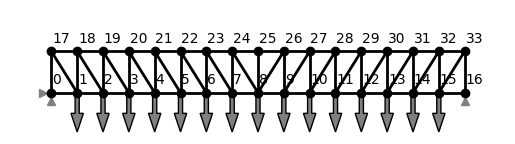

In [2]:
# Dimensions
A = 17
B = 2

# Nodes
n1 = torch.linspace(0.0, 5.0, A)
n2 = torch.linspace(0.0, 0.5, B)
n1, n2 = torch.stack(torch.meshgrid(n1, n2, indexing="xy"))
nodes = torch.stack([n1.ravel(), n2.ravel()], dim=1)

# Elements
connections = []
for i in range(A - 1):
    for j in range(B):
        connections.append([i + j * A, i + 1 + j * A])
for i in range(A):
    for j in range(B - 1):
        connections.append([i + j * A, i + A + j * A])
for i in range(A - 1):
    for j in range(B - 1):
        if i >= (A - 1) / 2:
            connections.append([i + j * A, i + 1 + A + j * A])
        else:
            connections.append([i + 1 + j * A, i + A + j * A])
elements = torch.tensor(connections)

# Create material
material = IsotropicElasticity1D(E=500.0)

# Create Truss
bridge = Truss(nodes.clone(), elements, material)

# Forces at bottom edge
bridge.forces[1 : A - 1, 1] = -0.1

# Constraints by the supports
bridge.constraints[0, 0] = True
bridge.constraints[0, 1] = True
bridge.constraints[A - 1, 1] = True

# Plot
bridge.plot()

We introduce some helper functions from the last exercises. These are just copies of functions you are already familiar with.

In [3]:
def compute_lengths(truss):
    start_nodes = truss.nodes[truss.elements[:, 0]]
    end_nodes = truss.nodes[truss.elements[:, 1]]
    dx = end_nodes - start_nodes
    return torch.linalg.norm(dx, dim=-1)


def box_constrained_decent(
    func, x_init, x_lower, x_upper, eta=0.01, max_iter=100, tol=1e-10
):
    x = x_init.clone().requires_grad_()
    for _ in range(max_iter):
        x_old = x.clone()
        grad = torch.autograd.grad(func(x).sum(), x)[0]
        x = x - eta * grad
        x = torch.clamp(x, x_lower, x_upper)
        if torch.norm(x - x_old) < tol:
            return x
    return x


def MMA(func, x_k, L_k, U_k):
    x_lin = x_k.clone().requires_grad_()
    grads = torch.autograd.grad(func(x_lin), x_lin)[0]
    pg = grads >= 0.0
    ng = grads < 0.0
    f_k = func(x_k)

    def approximation(x):
        p = torch.zeros_like(grads)
        p[pg] = (U_k[pg] - x_k[pg]) ** 2 * grads[pg]
        q = torch.zeros_like(grads)
        q[ng] = -((x_k[ng] - L_k[ng]) ** 2) * grads[ng]
        return (
            f_k
            - torch.sum(p / (U_k - x_k) + q / (x_k - L_k))
            + torch.sum(p / (U_k - x) + q / (x - L_k))
        )

    return approximation, grads

## Task 1 - Preparation of design variables

We want to restrict the shape optimization problem to the vertical displacement of the top nodes. Other nodes should not be modified - the train track should remain a flat line.

a) Create a boolean tensor `mask` of the same shape as `nodes`. It should be `True` for the vertical degrees of freedom of the top nodes and `False` for every other degree of freedom. Essentially it should mask out those nodal degrees of freedom which should be optimized. 

*Hints:* Take a look at how the boolean `constraints` tensor is created in a cell above. Take a look at the plot of the bridge to see which node numbers are the top nodes.)

In [4]:
# Implement the solution here


b) Create initial values `x_0` of the masked top node positions. Set limits to the deformation (`x_min`, `x_max`) such that nodes can move down by 0.4 and up by 0.5 units.

*Hints:* Use the `mask` tensor to extract the top node positions and use `ravel()`to flatten the tensor to get a vector of our design variables. 


In [5]:
# Implement the solution here

c) Compute the current volume of the truss `V0`. We will use this as a constraint in the optimization problem such that the optimized solution does not exceed this initial volume.

*Hint:* The current volume is the inner product of the current bar lengths and the cross-sectional `areas` of the bars.

In [6]:
# Implement the solution here

## Task 2 - Optimization

In this task, we will optimize the shape of the truss by minimizing the compliance of the bridge by adjusting the top nodes while keeping the volume constant: 

$$
\min_{\mathbf{x}} \quad C(\mathbf{x}) = \mathbf{f} \cdot \mathbf{u}(\mathbf{x}) \\
\text{s.t.} \quad \mathbf{a} \cdot \mathbf{l}(\mathbf{x}) - V_0 \le 0\\
\quad \quad x \in [\mathbf{x}^{-}, \mathbf{x}^{+}]
$$

a) Complete the objective function f(x). 

*Hint:* Replace `bridge.nodes[mask]` with the design variables `x` to update the nodal positions of the top nodes. Use `truss.solve()` to compute the displacements and forces of the updated truss. Use `ravel()` to flatten the tensors and compute the compliance as the inner product of the forces and displacements.

In [7]:
def f(x):
    # Update the masked nodes

    # Solve truss with updated nodes

    # Return compliance
    pass

b) Complete the constraint function g(x).

*Hint:* Replace `bridge.nodes[mask]` with the design variables `x` to update the nodal positions of the top nodes.

In [8]:
def g(x):
    # Update nodes

    # Return constraint function
    pass

c) Implement the updates of upper and lower asymptotes as in Exercise 04. 

d) Implement the lower and upper move limits called `x_min_k` and `x_max_k`.

e) Compute the approximated functions `f_tilde` and `g_tilde`. 

*Hints:* The MMA function returns the approximated functions `f_tilde` as well as the gradients of the original functions. You can assign them as follows: `f_tilde, f_Grad = MMA(...)`.

f) Implement the approximated Lagrangian $L = \tilde{f}(\mathbf{x}) + \mu \tilde{g}(\mathbf{x}) $

g) Implement the analytical solution of `x_star(mu)`. 

*Hints:* This is similar to the analytical solutions in Exercise 04. Start by defining an empty stationary point `x_hat` filled with zeros of the same shape as `f_grad`. Then, define the conditions for the four cases of the analytical solution and fill the `x_hat` tensor accordingly by setting `x_hat[cond1] = solution1` etc. Finally, clamp the results with the move limits. 

h) Implement the negative dual function $-\underbar{L}(\mu) = -L(x^*(\mu), \mu)$

i) Solve for the maximum of the dual function with `box_constrained_decent(...)`.

j) Append the solution to the list of solutions `x` = [$\mathbf{x}^0, \mathbf{x}^1, \mathbf{x}^2, ...$] containing the iteration steps of the optimization procedure. 

In [9]:
s = 0.7

# Set up lists for L, U, x
L = []
U = []
x = [x_0]

# Define the initial value, lower bound, and upper bound of "mu"
mu_0 = torch.tensor([0.01])
mu_lower = torch.tensor([1e-10])
mu_upper = None

for k in range(50):
    # Update asymptotes with heuristic procedure (see Exercise 04)

    # Compute lower and upper move limit in this step

    # Compute the current approximation function and save gradients

    # Define the Lagrangian
    def Lagrangian(x, mu):
        pass

    # Define x_star by minimizing the Lagrangian w. r. t. x analytically
    def x_star(mu):
        pass

    # Define (-1 times) the dual function
    def dual_function(mu):
        pass

    # Compute the maximum of the dual function

    # Compute current optimal point with dual solution

NameError: name 'x_0' is not defined

In [ ]:
# Plot the development of design variables
plt.plot(torch.stack(x).detach())
plt.xlabel("Iteration")
plt.ylabel("Values $x_i$")
plt.show()

# Plot the optimized bridge
bridge.plot(node_labels=False)